In [10]:
import numpy as np
from matplotlib import pyplot as plt 
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm, trange
import time
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
%config Completer.use_jedi = False

In [2]:
# 27 dec 2022
# extracting trends table
# Create an URL object
trends_url = "https://www.dotabuff.com/heroes/trends"
# Create object page
trends_page = requests.get(trends_url, headers = {'User-agent': 'personal_study'})
# Obtain page's information
trends_soup = BeautifulSoup(trends_page.text)
# trends_soup

# Obtain information from tag <table>
trends_table = trends_soup.findAll('table')[0]

In [3]:
# 27 dec 2022
# extracting the trends table into df
trends_header = [i.text for i in trends_table.find_all('tr')[2].find_all('th')]
trends_header = ['hero', 'wr_start', 'wr_current', 'wr_change', 'wr_trend', 'pr_start', 'pr_current', 'pr_change', 'pr_trend','title']


df_trends = []
for row in trends_table.find_all('tr'):
    
    try:
        link = row.find_all('a')[0]['href']
        link = link.split('/')[-1]
        title = row.find_all('img')[0]['title']
#         print(link)
    except:
        pass
    row = [i.text for i in row.find_all('td')]
#     print(row)
    if row !=[]:
        row[0] = link
        row.append(title)
        df_trends.append(row)
        
        
df_trends = pd.DataFrame(df_trends)
df_trends.columns = trends_header

df_trends = df_trends.drop(columns=['wr_trend','pr_trend'])
float_header  = ['wr_start', 'wr_current', 'wr_change', 'pr_start', 'pr_current', 'pr_change', ]
for i in float_header:
    df_trends[i] = df_trends[i].replace('','0.0%').str.rstrip('%').astype('float')
#     df_trends[i] = df_trends[i].replace('',)
df_trends


,hero,wr_start,wr_current,wr_change,pr_start,pr_current,pr_change,title
0,muerta,46.56,50.60,4.04,25.01,18.75,-6.26,Muerta
1,bane,46.75,48.88,2.12,2.29,2.03,-0.27,Bane
2,visage,51.41,53.38,1.97,1.09,0.96,-0.13,Visage
3,chen,46.59,48.55,1.96,0.57,0.58,0.00,Chen
4,death-prophet,47.74,49.15,1.41,4.56,5.03,0.47,Death Prophet
...,...,...,...,...,...,...,...,...
119,lycan,54.67,53.62,-1.05,2.06,2.70,0.64,Lycan
120,dark-seer,51.89,50.77,-1.11,1.75,1.92,0.17,Dark Seer
121,arc-warden,53.04,51.86,-1.18,4.49,4.45,0.00,Arc Warden
122,leshrac,47.98,46.52,-1.46,3.02,2.84,-0.19,Leshrac


In [4]:
# 27 dec 2022
# extracting names and winrates
df_wr = df_trends[['hero','wr_current','title']]
df_wr.columns = ['hero','wr','title']
df_wr = df_wr.sort_values(by='wr',ascending=False)
df_wr = df_wr.reset_index(drop=True)
df_wr['id'] = df_wr.index
df_wr.head()
# df_wr['hero'].tolist()

,hero,wr,title,id
0,clinkz,55.76,Clinkz,0
1,spectre,55.36,Spectre,1
2,silencer,54.47,Silencer,2
3,anti-mage,54.18,Anti-Mage,3
4,jakiro,54.01,Jakiro,4


In [5]:
def extract_counters(Hero):
    url_counter = f'https://www.dotabuff.com/heroes/{Hero}/counters'
    # print(url_counter)
    # Create object page
    page_counter = requests.get(url_counter, headers = {'User-agent': 'personal_study'})
    # Obtain page's information
    soup_counter = BeautifulSoup(page_counter.text)
    # trends_soup

    # Obtain information from tag <table>
    table_counter = soup_counter.findAll('table')[3]
#     print(table_counter.find_all('tr')[1].find_all('td')[0])
    header_counter = ['','title_B', 'disadvantage_AB', 'wr_AB', 'num_matches_AB']
    table_counter = [
        [j.text for j in i.find_all('td')]
        for i in table_counter.find_all('tr')
        if i.find_all('td') != []
    ]
    df_counters = pd.DataFrame(table_counter)
#     print(df_counters)
    df_counters.columns = header_counter
    df_counters['wr_AB'] = df_counters['wr_AB'].str.rstrip('%').astype('float')
    df_counters['disadvantage_AB'] = df_counters['disadvantage_AB'].str.rstrip('%').astype('float')
    df_counters['num_matches_AB'] = df_counters['num_matches_AB'].str.replace(',','').astype('int')
    return df_counters
    
extract_counters(df_wr['hero'][0])


,,title_B,disadvantage_AB,wr_AB,num_matches_AB
0,,Bounty Hunter,3.50,51.90,78563
1,,Bristleback,3.20,54.44,61015
2,,Drow Ranger,3.07,49.98,156196
3,,Slardar,2.84,51.42,55699
4,,Silencer,2.40,48.35,138186
...,...,...,...,...,...
118,,Anti-Mage,-2.32,54.03,118907
119,,Sand King,-2.41,56.57,46505
120,,Lycan,-2.80,53.08,17748
121,,Pangolier,-2.81,61.98,39365


In [6]:
heros = df_wr['hero'].tolist()
df_all_counters = []
p_bar = tqdm(heros)
for hero in p_bar:
    p_bar.set_description(f'Working on "{hero}"\n')
    df_counter_now = extract_counters(Hero=hero)
    df_counter_now['hero_A'] = hero
#     display(df_counter_now)
    try:
        df_all_counters = pd.concat([df_all_counters,df_counter_now])
#         break
    except TypeError:
        df_all_counters = df_counter_now
df_all_counters.head()

  0%|          | 0/124 [00:00<?, ?it/s]

,,title_B,disadvantage_AB,wr_AB,num_matches_AB,hero_A
0,,Bounty Hunter,3.50,51.90,78563,clinkz
1,,Bristleback,3.20,54.44,61015,clinkz
2,,Drow Ranger,3.07,49.98,156196,clinkz
3,,Slardar,2.84,51.42,55699,clinkz
4,,Silencer,2.40,48.35,138186,clinkz


In [7]:
df_t = df_all_counters.merge(df_wr,left_on='title_B',right_on='title',how='inner')
df_t = df_t.rename(columns={'hero':'hero_B','id':'id_B'})
df_t = df_t.merge(df_wr,left_on='hero_A',right_on='hero',how='inner')
df_t = df_t.rename(columns={'id':'id_A'})
filter_cols = ['id_A','id_B','wr_AB']
df_t = df_t[filter_cols]
df_t = df_t.sort_values(by=['id_A','id_B'])
df_t

,id_A,id_B,wr_AB
7,0,1,46.97
4,0,2,48.35
118,0,3,54.03
106,0,4,53.32
14,0,5,50.36
...,...,...,...
15072,123,118,49.32
15036,123,119,51.14
15033,123,120,53.13
15045,123,121,52.37


In [8]:
df_plot = np.identity(124)*50
# df_plot = np.zeros([124,124])
for row in df_t.values:
    a = int(row[0])
    b = int(row[1])
    if a!=b:
        df_plot[a,b] = row[2]
    else:
        df_plot[a,b] = 50
    
df_plot =  pd.DataFrame(df_plot)
df_plot = df_plot.rename(columns= df_wr['hero'],index=df_wr['hero'])
df_plot

,clinkz,spectre,silencer,anti-mage,jakiro,axe,meepo,legion-commander,lycan,dazzle,...,pangolier,morphling,tiny,enchantress,templar-assassin,broodmother,batrider,terrorblade,natures-prophet,lina
clinkz,50.00,46.97,48.35,54.03,53.32,50.36,52.72,49.47,53.08,50.46,...,61.98,58.17,58.08,58.98,60.94,57.51,60.67,60.67,60.38,59.88
spectre,53.03,50.00,53.24,48.43,52.09,55.89,47.63,52.76,47.18,50.33,...,58.48,58.10,60.42,58.31,63.80,56.28,60.13,60.45,64.32,60.13
silencer,51.65,46.76,50.00,51.80,51.60,53.08,51.65,48.10,46.39,52.96,...,58.88,57.15,57.95,57.97,60.05,55.57,60.89,59.20,58.33,58.56
anti-mage,45.97,51.57,48.20,50.00,49.21,47.61,39.08,45.56,47.85,49.49,...,55.85,60.41,54.68,55.69,57.19,56.88,61.02,57.11,58.23,55.28
jakiro,46.69,47.92,48.39,50.79,50.00,50.67,55.72,48.31,50.25,50.01,...,56.43,56.63,56.53,56.60,59.00,56.31,58.25,59.79,58.17,56.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
broodmother,42.50,43.72,44.43,43.12,43.69,41.76,37.55,40.32,42.55,44.37,...,49.77,52.89,51.05,51.42,52.79,50.00,50.04,49.92,54.48,48.86
batrider,39.33,39.90,39.12,38.98,41.75,43.91,42.56,36.73,42.45,41.33,...,47.30,48.10,48.72,47.17,53.27,49.94,50.00,50.72,51.35,46.87
terrorblade,39.33,39.55,40.80,42.89,40.21,36.90,43.08,39.75,43.43,40.17,...,47.07,49.14,49.93,48.65,53.36,50.08,49.28,50.00,51.73,47.63
natures-prophet,39.62,35.68,41.67,41.77,41.84,39.41,39.26,38.90,39.20,41.18,...,49.68,47.13,48.09,48.70,49.22,45.52,48.64,48.27,50.00,47.68


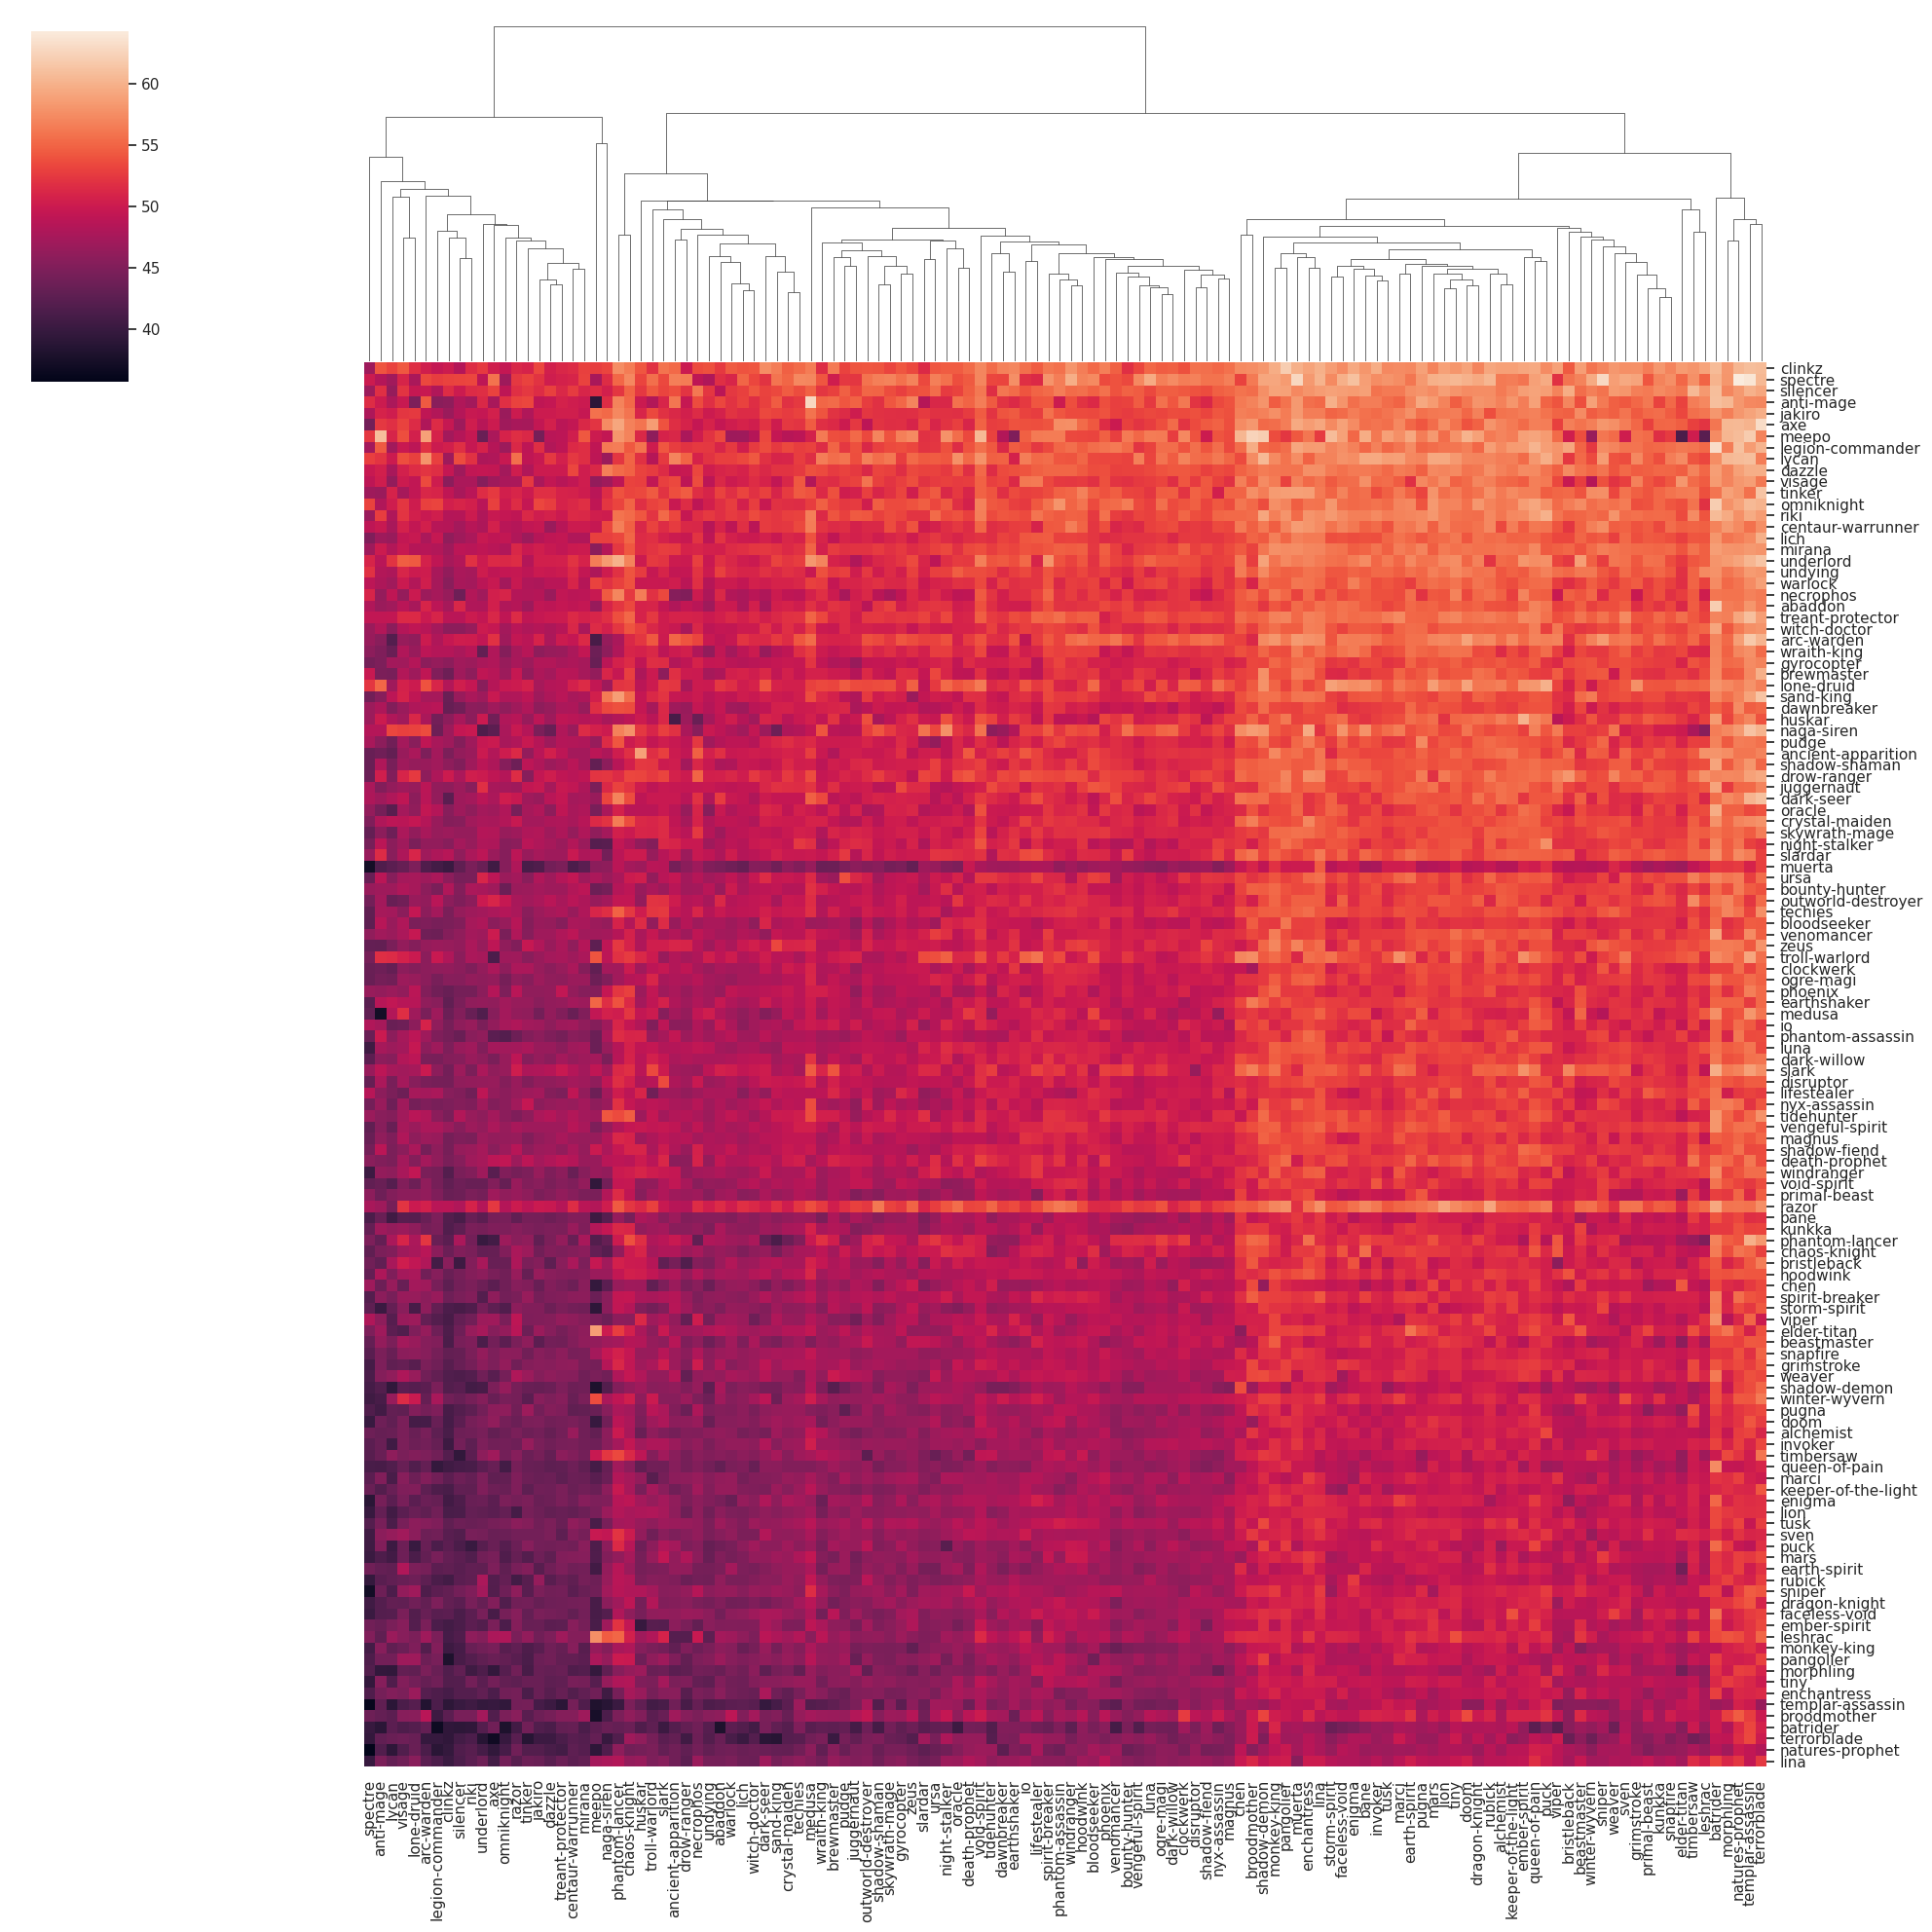

In [14]:
# df_plot.plot()
sns.set(font_scale=1)

# Default plot
sns.clustermap(
    df_plot,
    yticklabels=True,
    xticklabels=True,
    figsize=(20,20),
    row_cluster=False,
)
# Show the graph
plt.show()

# # Standardize or Normalize every column in the figure
# # Standardize:
# sns.clustermap(df_plot, standard_scale=1,yticklabels=True,xticklabels=True,figsize=(20,20))
# plt.show()

# # Normalize
# sns.clustermap(df_plot, z_score=1,yticklabels=True,xticklabels=True,figsize=(20,20))
# plt.show()

# # plot with correlation distance
# sns.clustermap(df_plot, metric="correlation",yticklabels=True,xticklabels=True,figsize=(20,20))
# plt.show()

# # plot with euclidean distance
# sns.clustermap(df_plot, metric="euclidean",yticklabels=True,xticklabels=True,figsize=(20,20))
# plt.show()

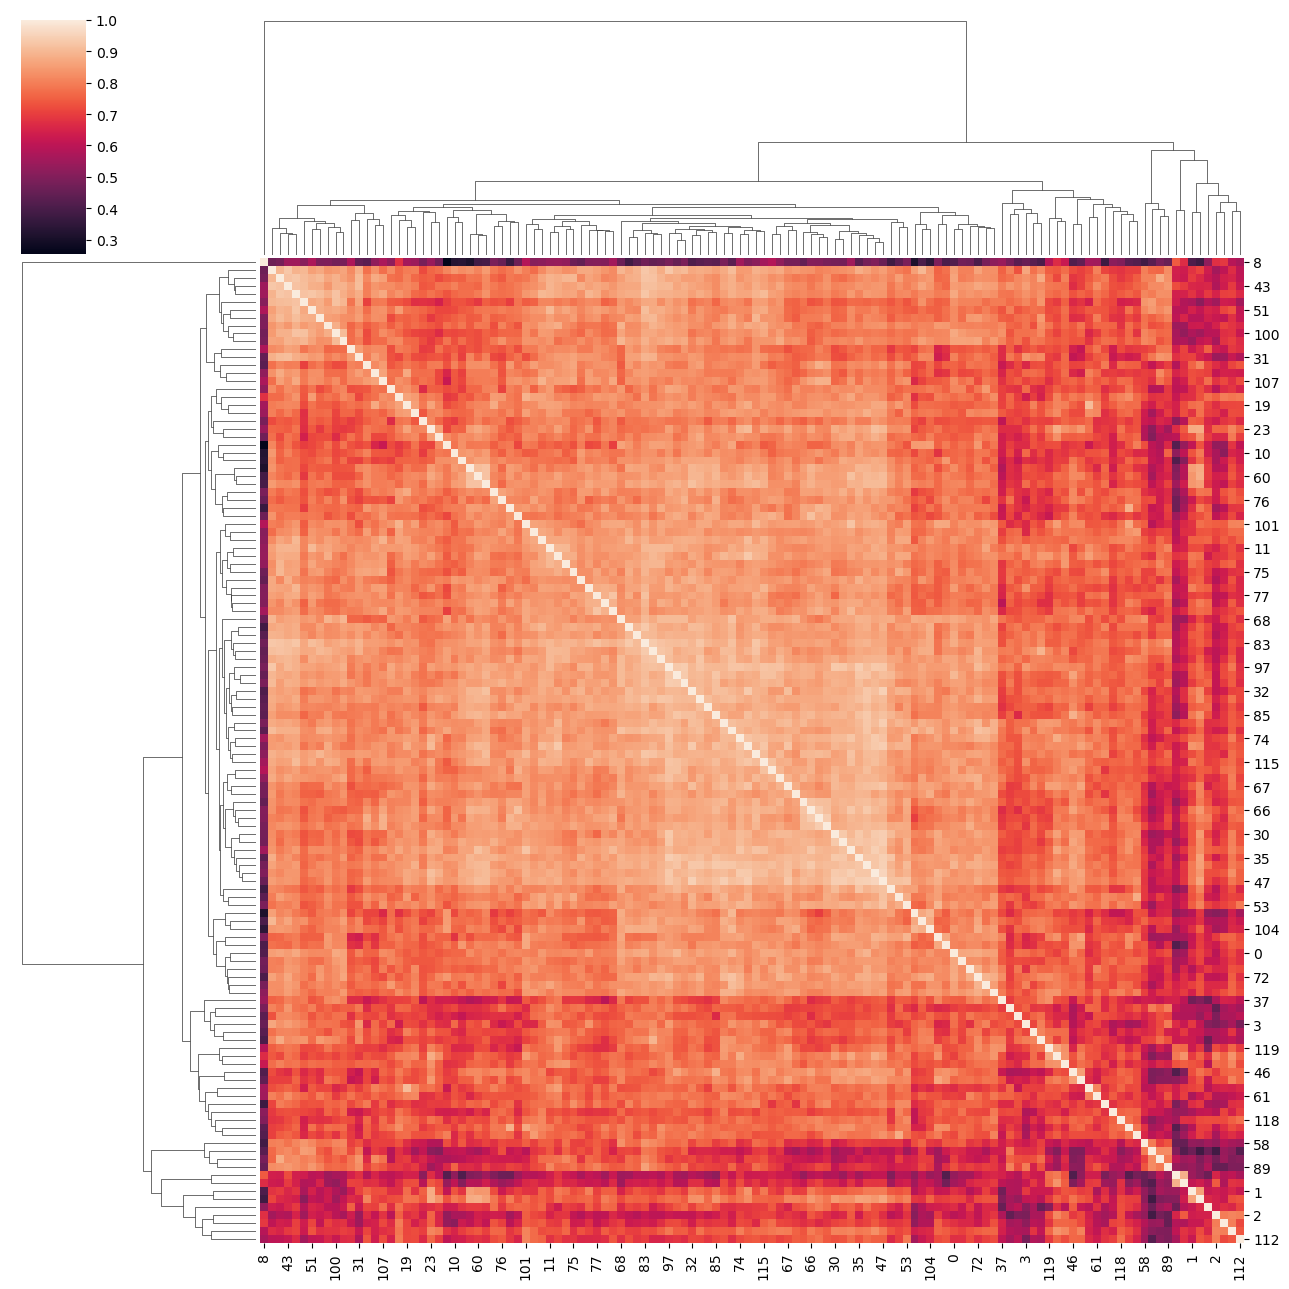

In [135]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

correlations = df_plot.corr()
correlations_array = np.asarray(df_plot.corr())

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')

sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage, method="average", figsize=(13, 13))

In [ ]:
# Q1.1
plt.figure()
plt.plot(np.arange(max_time+1),avg_states_UNVAC,label=f'UNVAC',linewidth=2)
plt.plot(np.arange(max_time+1),avg_states_FRIENDS,label=f'FRIENDS',linewidth=2)
plt.plot(np.arange(max_time+1),avg_states_RANDOM,label=f'RANDOM',linewidth=2)

# plt.plot(np.arange(1,101),cost_s,label=f'softmax',linewidth=2)

plt.title(f'HW4 Q1.3')
plt.xlabel("t",fontweight="bold")
plt.ylabel("number of nodes infected",fontweight="bold")
legend = plt.legend(title="Strategy",fontsize=7,loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

In [210]:
# finding standard deviations of heros counter winrates
stds = []
dev_50 = []
num_50 = []
for hero in heros:
    df_i = df_all_counters.copy(deep=True)
    df_i = df_i[df_i['hero0'] == hero]
    std = df_i['wr'].std()
    stds.append(std)
    
    d50 = sum((df_i['wr']-50)**2)
    dev_50.append(d50)
    
    n50 = df_i[df_i['wr']>=50]
    n50 = len(n50)
    num_50.append(n50)

#     display(df_i)
#     break
df_wr['dev_50'] = dev_50
df_wr['num_50'] = num_50
df_wr['std'] = stds
df_wr['temp'] = df_wr['std']*df_wr['wr']/100
df_wr1 = df_wr.sort_values(by=['wr'],ascending=False)
df_wr1 = df_wr.sort_values(by=['dev_50'],ascending=False)
df_wr1 = df_wr.sort_values(by=['num_50'],ascending=False)

df_wr1.head(20)

/tmp/ipykernel_11011/4209082686.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wr['dev_50'] = dev_50
/tmp/ipykernel_11011/4209082686.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wr['num_50'] = num_50
/tmp/ipykernel_11011/4209082686.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,Hero,wr,dev_50,num_50,std,temp
119,razor,54.83,5279.4359,119,2.847546,1.561310
29,silencer,55.65,5341.7968,117,2.920725,1.625383
48,drow-ranger,54.17,3754.8941,116,2.762116,1.496238
96,treant-protector,53.75,2598.5257,115,2.537825,1.364081
74,dazzle,53.06,2531.0381,113,2.716483,1.441366
21,riki,54.81,4179.8665,113,2.962567,1.623783
77,clinkz,53.26,3423.9501,112,3.084712,1.642917
13,omniknight,53.36,2561.4858,111,2.664482,1.421768
17,legion-commander,54.20,3008.3280,110,2.966255,1.607710
3,arc-warden,54.62,3491.8106,109,3.358543,1.834436


In [206]:
num_50 = []
for hero in heros:
    df_i = df_all_counters.copy(deep=True)
    df_i = df_i[df_i['hero0'] == hero]
    n50 = len(df_i[df_i['wr']>=50])
    num_50.append

underlord 103
beastmaster 34
outworld-destroyer 73
arc-warden 109
batrider 3
tinker 94
brewmaster 63
broodmother 24
meepo 98
monkey-king 8
terrorblade 6
wraith-king 72
ember-spirit 21
omniknight 111
io 46
shadow-demon 7
techies 80
legion-commander 110
disruptor 79
abaddon 88
marci 26
riki 113
lina 15
tiny 23
spectre 108
puck 16
centaur-warrunner 100
weaver 56
necrophos 67
silencer 117
shadow-shaman 90
elder-titan 49
chaos-knight 58
phantom-assassin 46
natures-prophet 1
dark-willow 71
crystal-maiden 100
zeus 74
tidehunter 77
ursa 64
medusa 58
templar-assassin 3
venomancer 68
sniper 45
earth-spirit 12
mars 23
clockwerk 63
lich 103
drow-ranger 116
spirit-breaker 56
morphling 13
gyrocopter 66
faceless-void 42
enchantress 15
witch-doctor 102
pudge 80
doom 26
keeper-of-the-light 11
slardar 92
magnus 39
timbersaw 23
axe 102
visage 98
lycan 103
hoodwink 58
snapfire 22
mirana 104
phoenix 59
warlock 98
phantom-lancer 69
pugna 13
grimstroke 42
lion 24
naga-siren 87
dazzle 113
invoker 28
huskar 68